In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download ('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Exploratory Data Analysis**



In [ ]:
# prompt: write a code to upload a data

from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving amazon_alexa (1).tsv to amazon_alexa (1).tsv
User uploaded file "amazon_alexa (1).tsv" with length 511601 bytes


In [4]:
# Import necessary libraries
import pandas as pd
from google.colab import files

# Step 1: Upload the data file
uploaded = files.upload()

# Step 2: Load the uploaded TSV file into a DataFrame
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

    # Read the TSV file
    data = pd.read_csv(fn, delimiter='\t', quoting=3)
    print(f'Dataset shape: {data.shape}')

# Optional: Display the first few rows of the dataset
print(data.head())


Saving amazon_alexa (1).tsv to amazon_alexa (1).tsv
User uploaded file "amazon_alexa (1).tsv" with length 511601 bytes
Dataset shape: (3150, 5)
   rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  "Sometimes while playing a game, you can answe...         1  
3  "I have had a lot of fun with this thing. My 4...         1  
4                                              Music         1  


In [5]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [6]:
# Checking for duplicate reviews
duplicates = data[data.duplicated(subset=['verified_reviews'], keep=False)]
print(f"Number of duplicate reviews: {duplicates.shape[0]}")

# Removing duplicates
data = data.drop_duplicates(subset=['verified_reviews'], keep='first')


Number of duplicate reviews: 1528


In [7]:
import pandas as pd

# Assuming 'data' is your DataFrame and 'rating' is a column with numerical values
Q1 = data['rating'].quantile(0.25)
Q3 = data['rating'].quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers
outliers = data[(data['rating'] < (Q1 - 1.5 * IQR)) | (data['rating'] > (Q3 + 1.5 * IQR))]
print(f"Number of outliers detected: {outliers.shape[0]}")


Number of outliers detected: 206


In [8]:
data_no_outliers = data[~data.index.isin(outliers.index)]


In [9]:
# Capping outliers at the 1st and 99th percentile
lower_bound = data['rating'].quantile(0.01)
upper_bound = data['rating'].quantile(0.99)

# Use .loc to avoid SettingWithCopyWarning
data.loc[:, 'rating'] = data['rating'].clip(lower_bound, upper_bound)


In [ ]:
print(f'Feature names : {data.columns.values}')

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [ ]:
#Check for Null Values
data.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [ ]:
#Getting the record where 'verified_reviews' is null

data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [ ]:
#We will drop the null record

data.dropna(inplace=True)

In [ ]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (3149, 5)


In [ ]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)

In [ ]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [ ]:
#Randomly checking for 11th record

print(f"'verified_reviews' column value: {data.iloc[11]['verified_reviews']}") #Original value
print(f"Length of review : {len(data.iloc[11]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[11]['length']}") #Value of the column 'length'

'verified_reviews' column value: I love it! Learning knew things with it eveyday! Still figuring out how everything works but so far it's been easy to use and understand. She does make me laugh at times
Length of review : 169
'length' column value : 169


In [ ]:
data.dtypes

,0
rating,int64
date,object
variation,object
verified_reviews,object
feedback,int64
length,int64


In [ ]:
len(data)

3149

In [ ]:
#Distinct values of 'rating' and its count

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


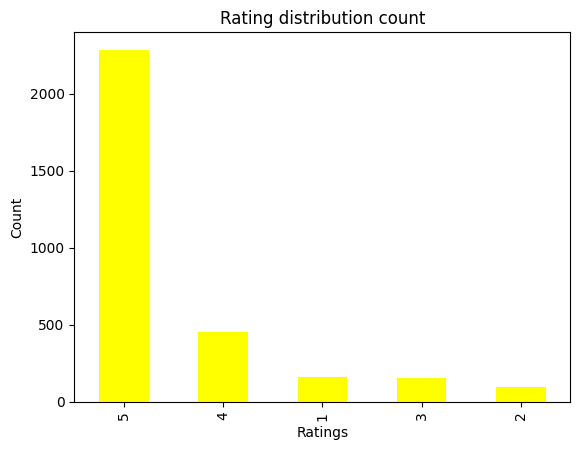

In [ ]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = 'yellow')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [ ]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


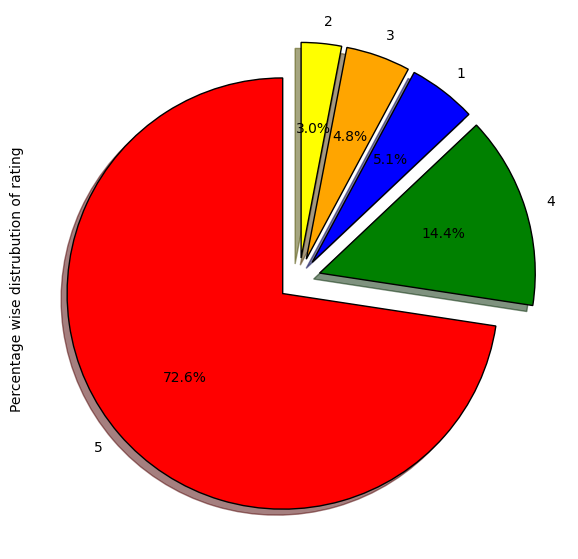

In [ ]:
#plotting a pie chart to get visual of the distributed data
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

In [ ]:
#Distinct values of 'feedback' and its count

print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


**There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.**

**feedback value = 0**


In [ ]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [ ]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


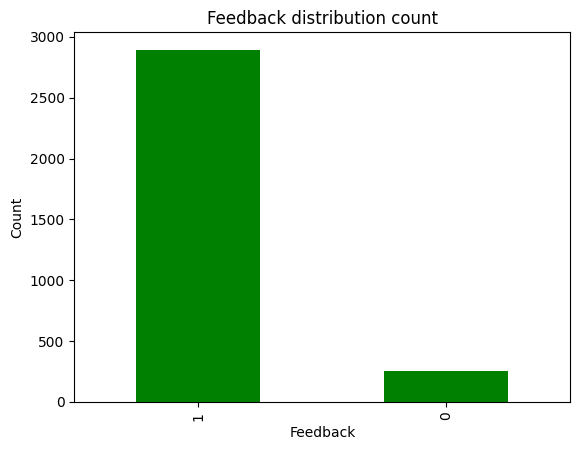

In [ ]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = 'Green')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [ ]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


<Axes: ylabel='Percentage wise distrubution of feedback'>

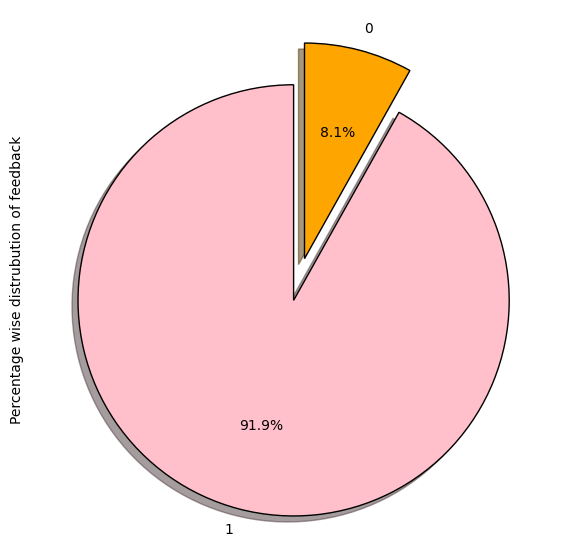

In [ ]:
fig = plt.figure(figsize=(7,7))

colors = ('Pink', 'orange')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

In [ ]:
#Let's see the 'rating' values for different values of 'feedback'
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

,count
rating,
1,161
2,95


In [ ]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

,count
rating,
5,2286
4,455
3,152


In [ ]:
#Distinct values of 'variation' and its count

print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


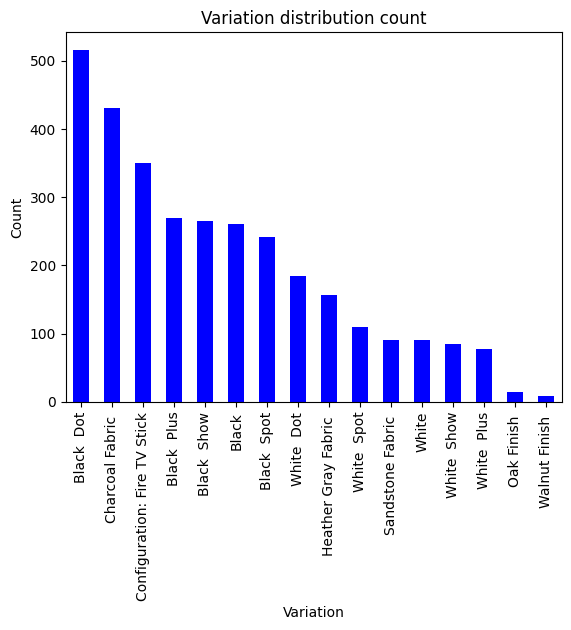

In [ ]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = 'blue')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [ ]:
data.groupby('variation')['rating'].mean()

,rating
variation,
Black,4.233716
Black Dot,4.453488
Black Plus,4.370370
Black Show,4.490566
Black Spot,4.311203
Charcoal Fabric,4.730233
Configuration: Fire TV Stick,4.591429
Heather Gray Fabric,4.694268
Oak Finish,4.857143


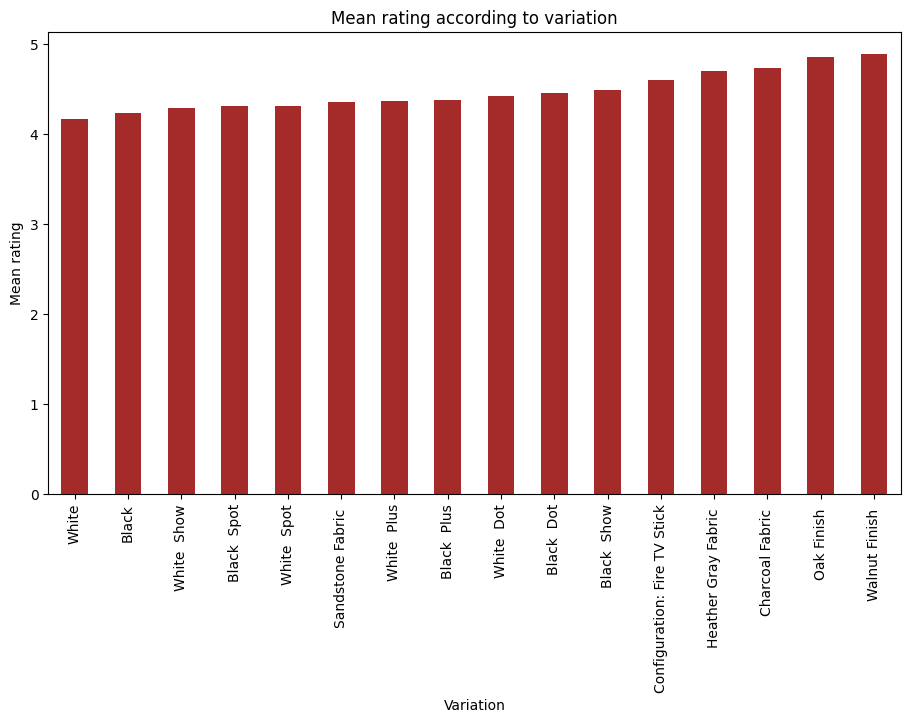

In [ ]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

In [ ]:
data['length'].describe()

,length
count,3149.000000
mean,132.714513
std,182.541531
min,1.000000
25%,30.000000
50%,74.000000
75%,166.000000
max,2853.000000


[Text(0.5, 1.0, 'Distribution of length of review ')]

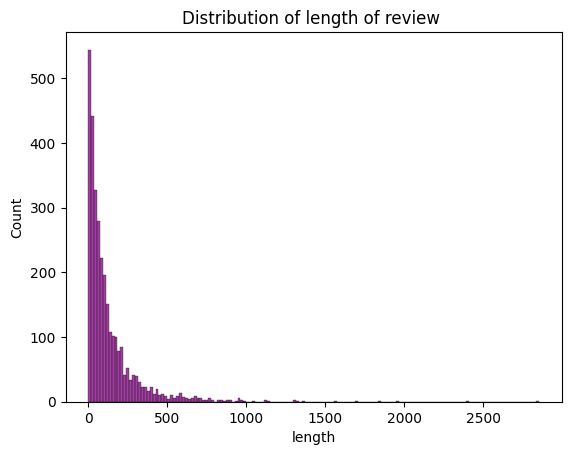

In [ ]:
sns.histplot(data['length'],color='purple').set(title='Distribution of length of review ')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

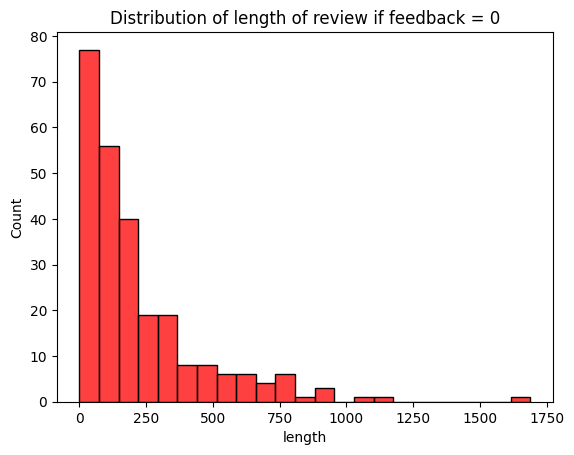

In [ ]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

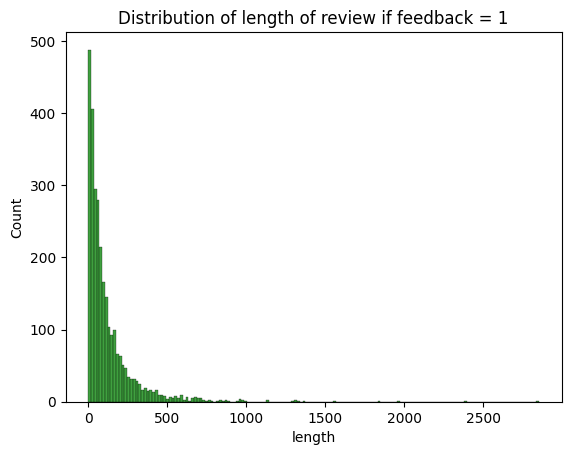

In [ ]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

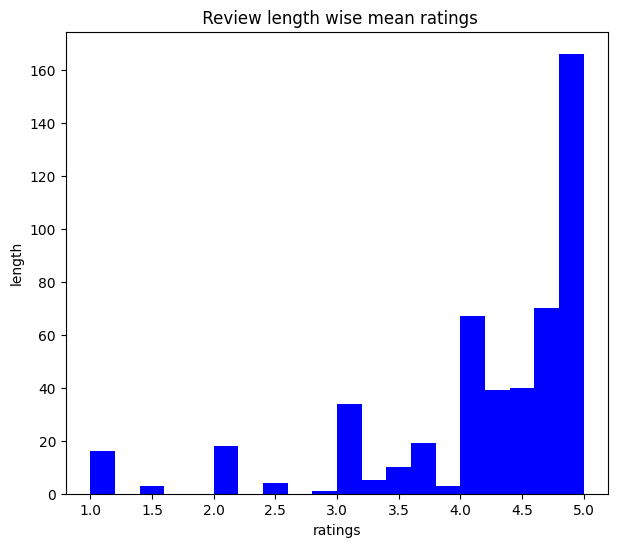

In [ ]:
#Lengthwise mean rating

data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [ ]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

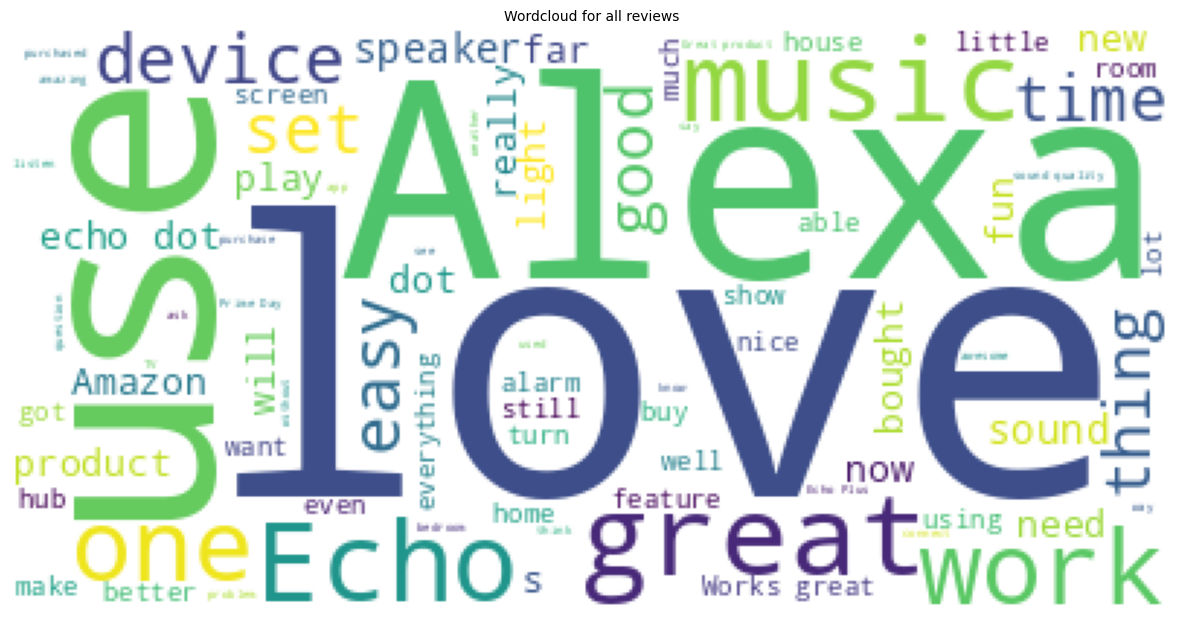

In [ ]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=80)

# Generate and plot wordcloud
plt.figure(figsize=(15,15))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [ ]:
#Lets find the unique words in each feedback category
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

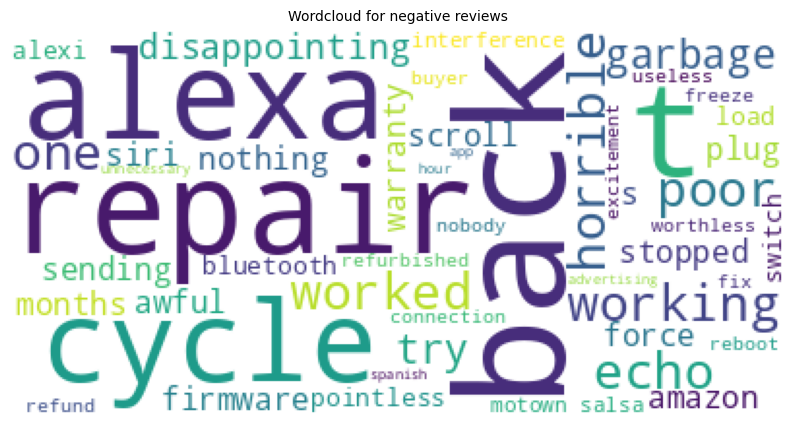

In [ ]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

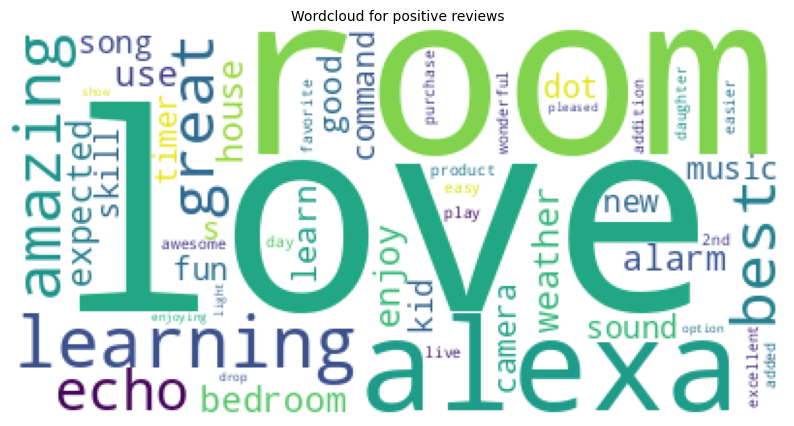

In [ ]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

# **Preprocessing and Modelling**
To build the corpus from the 'verified_reviews' we perform the following -


1.   Replace any non alphabet characters with a space
2.   Covert to lower case and split into words
3.   Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [ ]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [ ]:
#Using Count Vectorizer to create a bag of words
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [ ]:
import os
import pickle

#Saving the Count Vectorizer
# Create the directory if it doesn't exist
os.makedirs('Models', exist_ok=True)

pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [ ]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [ ]:
#Checking the shape of x & y
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


In [ ]:
#Splitting data into train and test set with 30% data with testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [ ]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


In [ ]:
#We'll scale X_train and X_test so that all values are between 0 and 1.
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [ ]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Assuming you have already defined your features X and target y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate the model
print("Training Accuracy:", model.score(X_train, y_train))
print("Testing Accuracy:", model.score(X_test, y_test))


Training Accuracy: 0.9777676950998185
Testing Accuracy: 0.9375661375661376


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Predictions
y_pred = model.predict(X_test)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[ 29  49]
 [ 10 857]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.37      0.50        78
           1       0.95      0.99      0.97       867

    accuracy                           0.94       945
   macro avg       0.84      0.68      0.73       945
weighted avg       0.93      0.94      0.93       945

